# GAN Art
_Auther: Esraa Madi_


## **Overview**

Our idea is merging something traditional with another thing not related to our culture 

We chose the sword to be our traditional thing which reflects a strong part of our history and "English letter" to see how our culture symbol affects the letters and creates like a new Saudi font with different angles, curves, and lines.

---




In [0]:
# import libraries --> system , plotting
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageDraw

# import libraries --> load files
from google.colab import drive
import glob
import pandas as pd

# import libraries --> model
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense,Dropout, Flatten, Input, Reshape, UpSampling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.utils import shuffle

%matplotlib inline

In [0]:
###define some paramters

# Input vector dimension
vector_noise_dim = 100

# Trining batch and epochs numbers
batch_size = 16
steps_per_epoch = 375 
epochs = 21
optimizer = Adam(0.0002, 0.5)

# Image dimentions, colors(channels)
img_rows, img_cols, channels = 28, 28, 1

# Consistent results
np.random.seed(444)

## **Datasets**


We started with collecting two sets of pictures: one for curved sword, one for English letters (we choosed here R letter images only since its shape match more with sword).
So in this project we will try to reconstract new images by training 2 these two datasetes on Gans model.

<br>

**The first dataset is taken from this [Kaggle dataset](https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format):**
* Contains 26 handweitten letters (A-Z) images.
* Image size 28*28 pixels.
* Each image is stored as Gray-level.
* Each alphabet in the image is centre fitted to 20*20 pixel box.
* Images are saved as .CSV file

**The second datasets for curved sword:**
* Used this [script]() to download all possible pictures.






<br>



After downloading .CSV file, I uploaded on the google driver. So our dataset will be loaded from my google driver.

<br>

> ![My google drive](https://drive.google.com/uc?id=1Tg7OsByUGkf34S_Eg3pCKrs1LynIBTOV)

In [5]:
# Do google driver authorization step
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive




#### 1.   English letters dataset:



In [0]:
# Load English letters dataset from my deiver 
letters_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/Letters_dataset/A_ZHandwrittenData.csv')

In [7]:
# Check first 5 rows in the dataset
letters_df.head(5)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617,0.618,0.619,0.620,0.621,0.622,0.623,0.624,0.625,0.626,0.627,0.628,0.629,0.630,0.631,0.632,0.633,0.634,0.635,0.636,0.637,0.638,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# First column is the label of letters as a number presents the letter order, ex 0:A , 1:b ..... 25:Z
letters_df.iloc[:6, 0]

0    0
1    0
2    0
3    0
4    0
5    0
Name: 0, dtype: int64

In [9]:
# dataframe columns
letters_df.columns

Index(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       ...
       '0.639', '0.640', '0.641', '0.642', '0.643', '0.644', '0.645', '0.646',
       '0.647', '0.648'],
      dtype='object', length=785)

In [0]:
# Rename dataframe columns

# Letters label
letters_df.rename(columns={'0':'letter'}, inplace=True)

# Pixels labels
letters_df.rename(columns={col_num : 'pixel_' + str(col_index) for col_index, col_num in enumerate(letters_df.columns[1:])}, inplace=True)

In [11]:
# Check first 5 rows in the dataset
letters_df.head(5)

,letter,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,...,pixel_744,pixel_745,pixel_746,pixel_747,pixel_748,pixel_749,pixel_750,pixel_751,pixel_752,pixel_753,pixel_754,pixel_755,pixel_756,pixel_757,pixel_758,pixel_759,pixel_760,pixel_761,pixel_762,pixel_763,pixel_764,pixel_765,pixel_766,pixel_767,pixel_768,pixel_769,pixel_770,pixel_771,pixel_772,pixel_773,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Map each number to its letter symbol

# Maping dict
alphabets_map_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',
                    6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',
                    12:'M',13:'N',14:'O',15:'P',16:'Q',
                    17:'R',18:'S',19:'T',20:'U',21:'V',
                    22:'W',23:'X',24:'Y',25:'Z'} 

# New dataframe with alphabets symbols
alphabets_df = letters_df.copy()

# Map numbers
alphabets_df['letter'] = alphabets_df['letter'].map(alphabets_map_dict)

In [13]:
# Check letters
np.array(set(alphabets_df['letter']))

array({'K', 'A', 'X', 'H', 'M', 'F', 'J', 'C', 'D', 'W', 'R', 'Q', 'V', 'Z', 'N', 'E', 'S', 'G', 'I', 'Y', 'B', 'O', 'U', 'L', 'P', 'T'},
      dtype=object)

In [0]:
# Create dataframe with only 'R' letter
r_df = alphabets_df[alphabets_df['letter']=='R'].copy()

In [15]:
# Check first 5 rows in 'R' dataset
r_df.head(5)

,letter,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,...,pixel_744,pixel_745,pixel_746,pixel_747,pixel_748,pixel_749,pixel_750,pixel_751,pixel_752,pixel_753,pixel_754,pixel_755,pixel_756,pixel_757,pixel_758,pixel_759,pixel_760,pixel_761,pixel_762,pixel_763,pixel_764,pixel_765,pixel_766,pixel_767,pixel_768,pixel_769,pixel_770,pixel_771,pixel_772,pixel_773,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
222789,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
222790,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
222791,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
222792,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
222793,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Splite data the X - pixels data , and y - the letter label
X = r_df.drop('letter',axis = 1).astype(np.float32)
y = r_df['letter']

In [0]:
# Check how images look like

def plot_images(df, img_size):
#    Function converts a sample of dataframe rows to actual images in .png format.
#         *Inputs: 
#                 df: datafram, each row contains 784 columns (pixles numnber 28*28)
#                 img_size: integer, size of image
#         *Return: 
#                 None, just plot images
            
    df_shuffle = shuffle(df)

    # Initialize image size
    plt.figure(figsize = (img_size, 6))

    # Number of images (rows * coulmns)
    rows, columns = 2, 4

    # loop to draw images
    for i in range(8):  
        plt.subplot(rows, columns, i+1)
        plt.imshow(df_shuffle.iloc[i].values.reshape(28,28), cmap='Greys')
    plt.show()

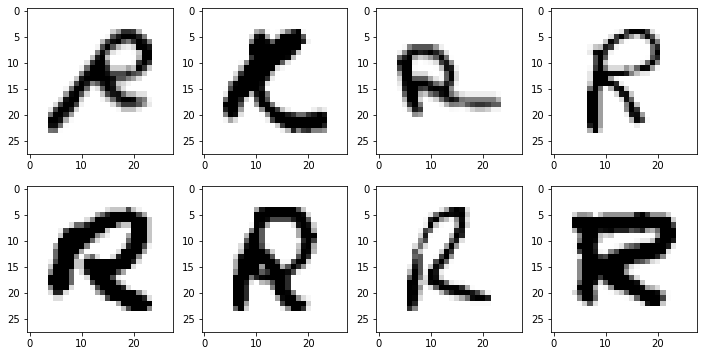

In [18]:
plot_images(X, 12)

In [0]:
# Preprocess images:

# Invert grayscale images
XI = X.applymap(lambda l: 255-l).copy()

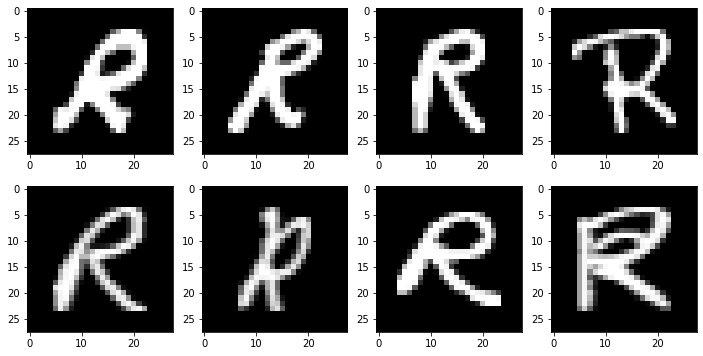

In [20]:
plot_images(XI, 12)

#### 2.   Curved Sword dataset:

In [0]:
# Load curved swords dataset from a folder in my driver
sword_images = glob.glob("/content/drive/My Drive/Colab Notebooks/datasets/Black_sword_dataset/*.jpg")

In [0]:
def gen_random_rotation(img, rot_range=90):
  # Function generates rotated images with given angle suing keras 
  # Input: 
  #       - img: string, image path 
  #       - rot_range: integer, rotation angle 
  # Return:
  #       - list of rotated images
  data = img_to_array(load_img(img, target_size=(28,28), color_mode = "grayscale"))
  samples = np.expand_dims(data, 0)
  # create image data augmentation generator
  datagen = ImageDataGenerator(rotation_range=rot_range)
  # prepare iterator
  it = datagen.flow(samples, batch_size=1)
  # generate samples and plot
  rot_img_list = []
  for i in range(9):
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    rot_img_list.append(image.reshape(28,28))
  return rot_img_list

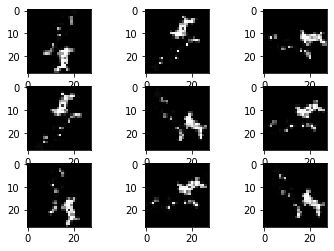

In [23]:
# Test how above rotate function works for the firat image 
sword_0 = sword_images[0]
for ind, img in enumerate(gen_random_rotation(sword_0)):
  # define subplot
  plt.subplot(330 + 1 + ind)
  # plot raw pixel data
  plt.imshow(img, cmap='Greys')

In [0]:
# loop over images in given folder and store original images and rotated images in different list
sword_list = []
rotate_sword_list = []
for image in sword_images:
  # read image
  img = cv2.imread(image,0)

  # generate rotated images
  rotate_sword_list.extend(gen_random_rotation(image))
  
  # resize image
  resized = cv2.resize(img, (img_rows, img_cols), interpolation = cv2.INTER_AREA)
  sword_list.append(np.array(resized))

In [25]:
# Check number of collected swords
len(sword_list)

131

In [26]:
# Check shape of images
sword_list[0].shape

(28, 28)

In [27]:
# Check number of rotated swords
len(rotate_sword_list)

1179

In [28]:
# Check shape of images
rotate_sword_list[0].shape

(28, 28)

In [0]:
# create a new dataframe for all collected and rotated sword

all_sword = np.array(rotate_sword_list + sword_list)

# dimention:  (#images, imagesize (28*28))
dim = (all_sword.shape[0], 784)
sword_df = pd.DataFrame(np.reshape(all_sword, dim), columns= list(letters_df.columns[1:]))

In [30]:
# Check sword datafram dataset
sword_df.shape

(1310, 784)

In [31]:
# check first 5 rows 
sword_df.head(5)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,pixel_39,...,pixel_744,pixel_745,pixel_746,pixel_747,pixel_748,pixel_749,pixel_750,pixel_751,pixel_752,pixel_753,pixel_754,pixel_755,pixel_756,pixel_757,pixel_758,pixel_759,pixel_760,pixel_761,pixel_762,pixel_763,pixel_764,pixel_765,pixel_766,pixel_767,pixel_768,pixel_769,pixel_770,pixel_771,pixel_772,pixel_773,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,251,246,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,251,248,254,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,253,253,254,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,254,244,245,246,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,252,250,...,255,255,255,206,192,255,254,253,253,254,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,253,253,254,255
4,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,242,247,249,254,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,232,254,254,209,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,148,176,250,253,254,255,255,255,255,255,255,255,255,255


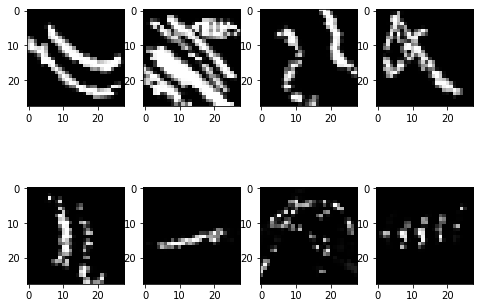

In [32]:
# plot some swords
plot_images(sword_df, 8)

So we have now 2 datasets, one for R letter and the other one for sword:

In [33]:
# R letter dataset
XI.head(2)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,pixel_39,...,pixel_744,pixel_745,pixel_746,pixel_747,pixel_748,pixel_749,pixel_750,pixel_751,pixel_752,pixel_753,pixel_754,pixel_755,pixel_756,pixel_757,pixel_758,pixel_759,pixel_760,pixel_761,pixel_762,pixel_763,pixel_764,pixel_765,pixel_766,pixel_767,pixel_768,pixel_769,pixel_770,pixel_771,pixel_772,pixel_773,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
222789,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
222790,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [34]:
# Sword dataset
sword_df.head(2)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,pixel_39,...,pixel_744,pixel_745,pixel_746,pixel_747,pixel_748,pixel_749,pixel_750,pixel_751,pixel_752,pixel_753,pixel_754,pixel_755,pixel_756,pixel_757,pixel_758,pixel_759,pixel_760,pixel_761,pixel_762,pixel_763,pixel_764,pixel_765,pixel_766,pixel_767,pixel_768,pixel_769,pixel_770,pixel_771,pixel_772,pixel_773,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,251,246,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,251,248,254,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255


In [0]:
# Our final dataset will be a subset of R letters and whole sword dataset
x_final = pd.concat([XI.iloc[:3000, :], sword_df], axis=0)

In [16]:
x_final.head(2)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,pixel_39,...,pixel_744,pixel_745,pixel_746,pixel_747,pixel_748,pixel_749,pixel_750,pixel_751,pixel_752,pixel_753,pixel_754,pixel_755,pixel_756,pixel_757,pixel_758,pixel_759,pixel_760,pixel_761,pixel_762,pixel_763,pixel_764,pixel_765,pixel_766,pixel_767,pixel_768,pixel_769,pixel_770,pixel_771,pixel_772,pixel_773,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
222789,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
222790,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [17]:
# Check shape
x_final.shape

(4310, 784)

In [0]:
x_final.to_csv("/content/drive/My Drive/Colab Notebooks/datasets/final_dataset.csv")

## **Modeling (GANs):**

Generative adversarial network (GAN) is a set of neural network models used to generate objects (here is images) by treating the original images (dataset) as a simple image reconstruction.

**A GAN consist of two types of neural networks:**
* Generator.
* Discriminator.


---






In [14]:
# Do google driver authorization step and reload the data
drive.mount('/content/drive')
x_final = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datasets/final_dataset.csv", index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
x_final.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,pixel_39,...,pixel_744,pixel_745,pixel_746,pixel_747,pixel_748,pixel_749,pixel_750,pixel_751,pixel_752,pixel_753,pixel_754,pixel_755,pixel_756,pixel_757,pixel_758,pixel_759,pixel_760,pixel_761,pixel_762,pixel_763,pixel_764,pixel_765,pixel_766,pixel_767,pixel_768,pixel_769,pixel_770,pixel_771,pixel_772,pixel_773,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
222789,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
222790,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
222791,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
222792,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
222793,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [0]:
# Preprocess data for modeling
# Normalize to between -1 and 1
x_final = (x_final.astype(np.float32) - 127.5) / 127.5
x_final = x_final.values.reshape(-1, img_rows*img_cols*channels)

In [0]:
def create_generator():
    # Function to build generator neural network
    # Inputs:
    # Return: 
    #        - neural network model of generator
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=vector_noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [0]:
def create_descriminator():
    # Function to build descriminator neural network
    # Inputs:
    # Return: 
    #        - neural network model of descriminator
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [21]:
# create generator and descriminator objects
discriminator = create_descriminator()
generator = create_generator()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
discriminator.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(vector_noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [0]:
# Create path for saving images
images_path = 'generated_images'
if images_path != None and not os.path.isdir(images_path):
    os.mkdir(images_path)

In [0]:
# Display images, and save them if the epoch number is specified
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None and images_path != None:
        plt.savefig(f'{images_path}/gan-images_epoch-{epoch}.png')
    plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: 0.4681953191757202 		 Generator Loss: 1.2624471187591553


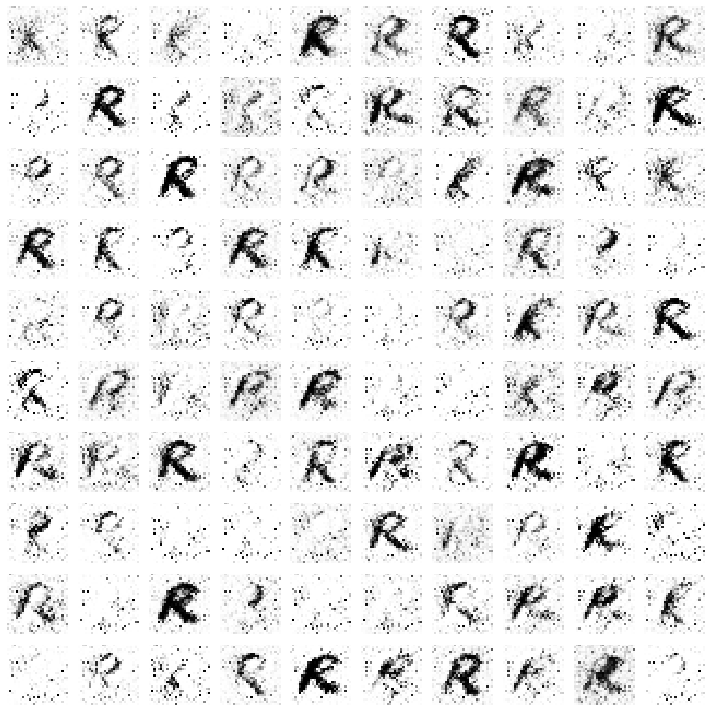

Epoch: 1 	 Discriminator Loss: 0.36959409713745117 		 Generator Loss: 2.4021570682525635


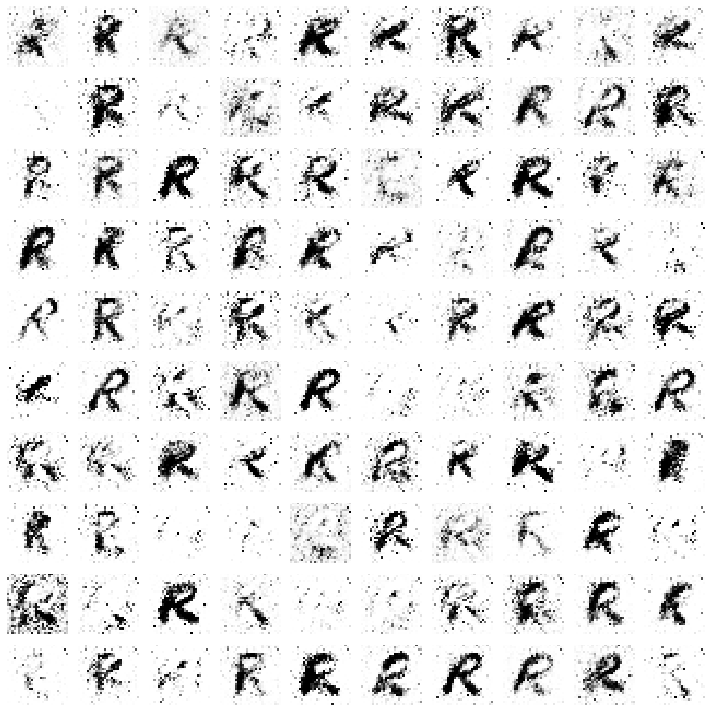

Epoch: 2 	 Discriminator Loss: 0.47282707691192627 		 Generator Loss: 1.8822271823883057


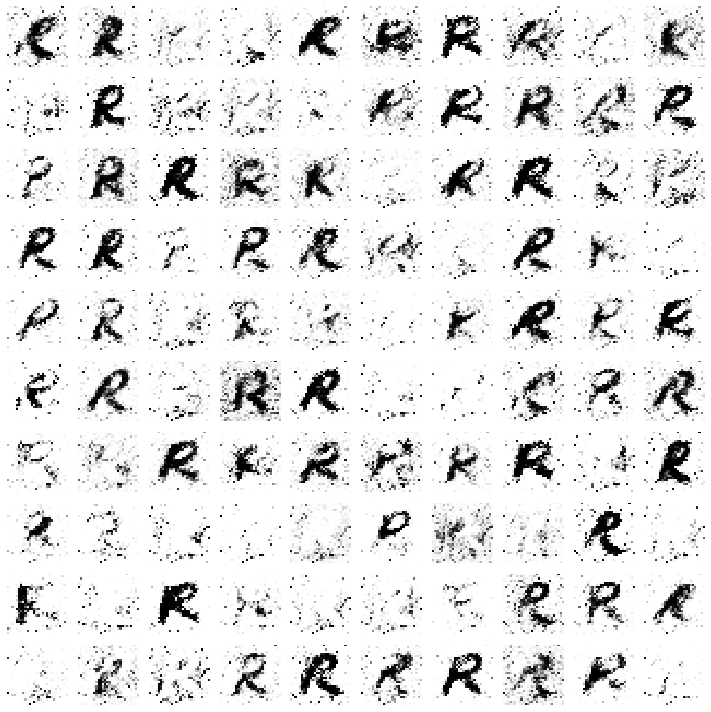

Epoch: 3 	 Discriminator Loss: 0.595879077911377 		 Generator Loss: 2.1805291175842285


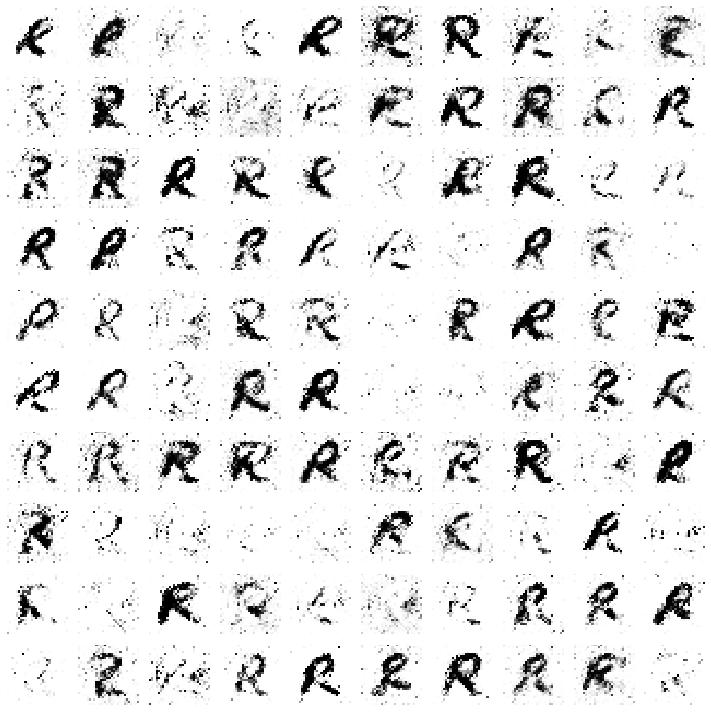

Epoch: 4 	 Discriminator Loss: 0.43388739228248596 		 Generator Loss: 2.9509897232055664


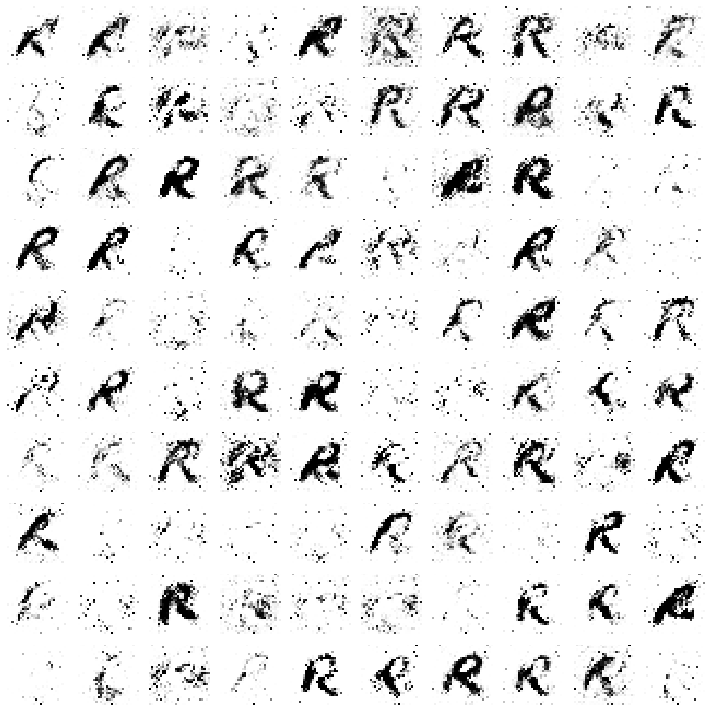

Epoch: 5 	 Discriminator Loss: 0.35448354482650757 		 Generator Loss: 2.0632338523864746


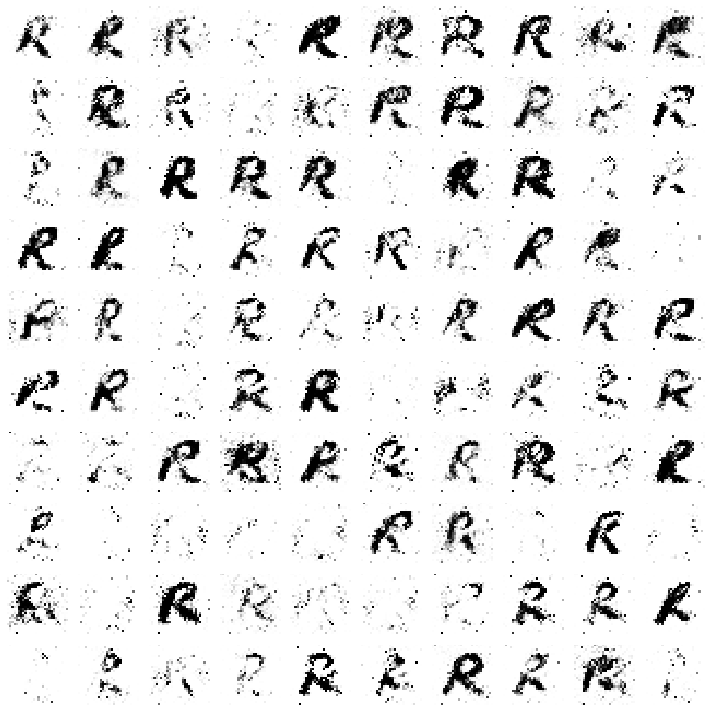

Epoch: 6 	 Discriminator Loss: 0.49141374230384827 		 Generator Loss: 2.121328592300415


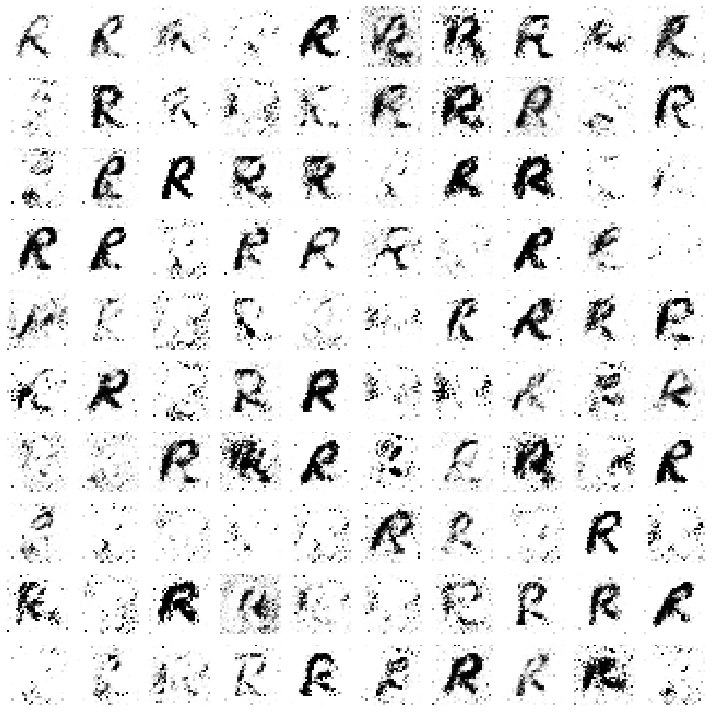

Epoch: 7 	 Discriminator Loss: 0.41459327936172485 		 Generator Loss: 1.993666648864746


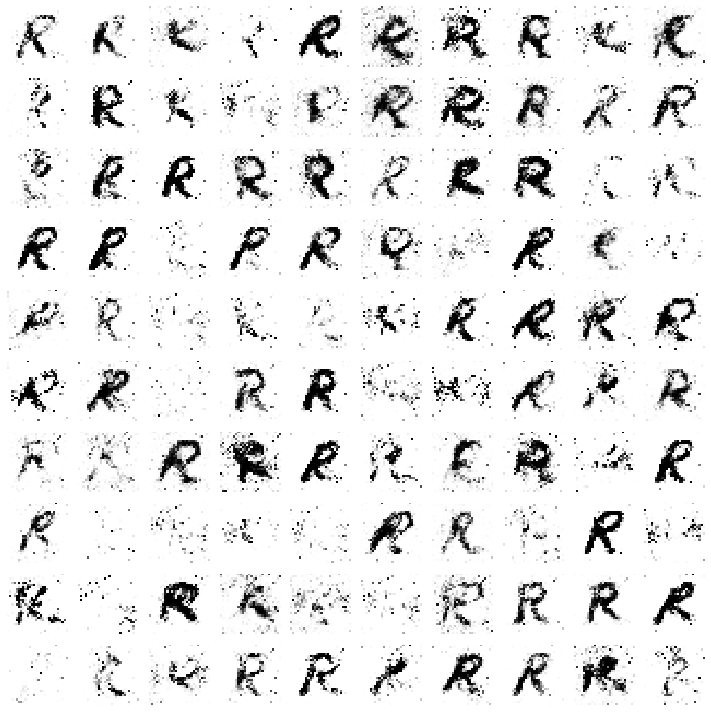

Epoch: 8 	 Discriminator Loss: 0.5105451941490173 		 Generator Loss: 1.7194981575012207


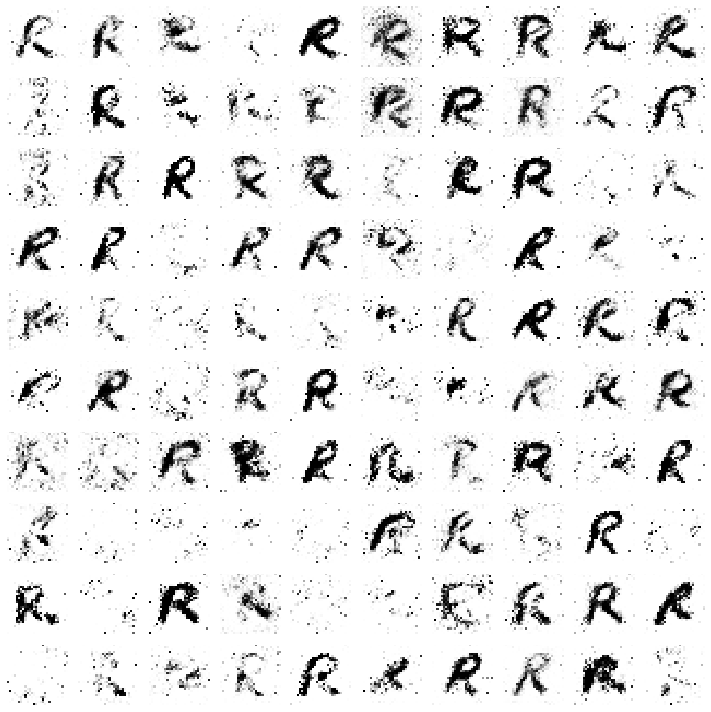

Epoch: 9 	 Discriminator Loss: 0.6798827648162842 		 Generator Loss: 1.2135460376739502


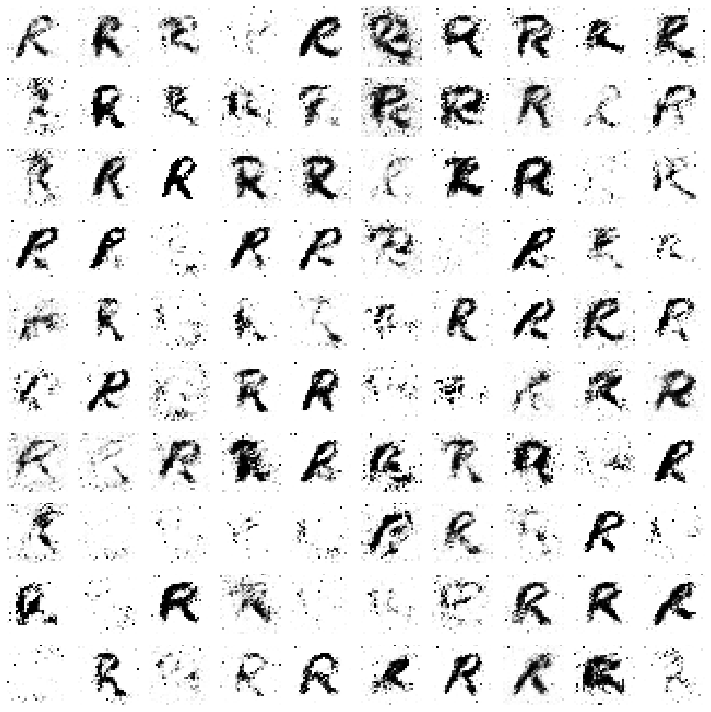

Epoch: 10 	 Discriminator Loss: 0.47117769718170166 		 Generator Loss: 2.059755325317383


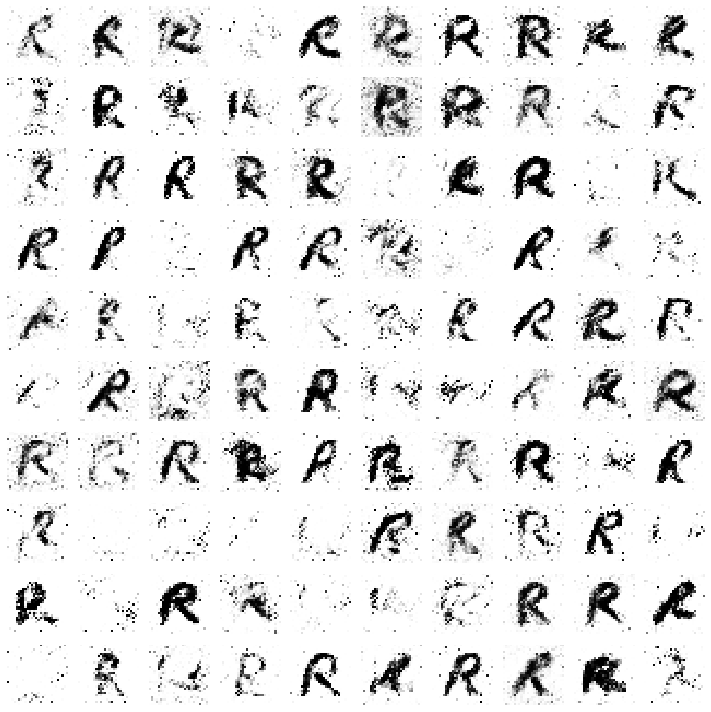

Epoch: 11 	 Discriminator Loss: 0.5298247337341309 		 Generator Loss: 1.9303303956985474


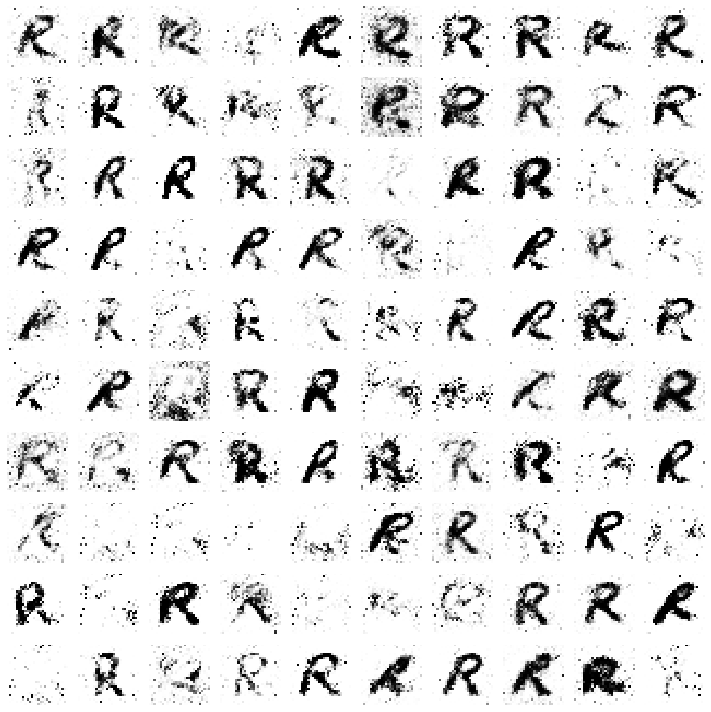

Epoch: 12 	 Discriminator Loss: 0.5929574966430664 		 Generator Loss: 1.9326664209365845


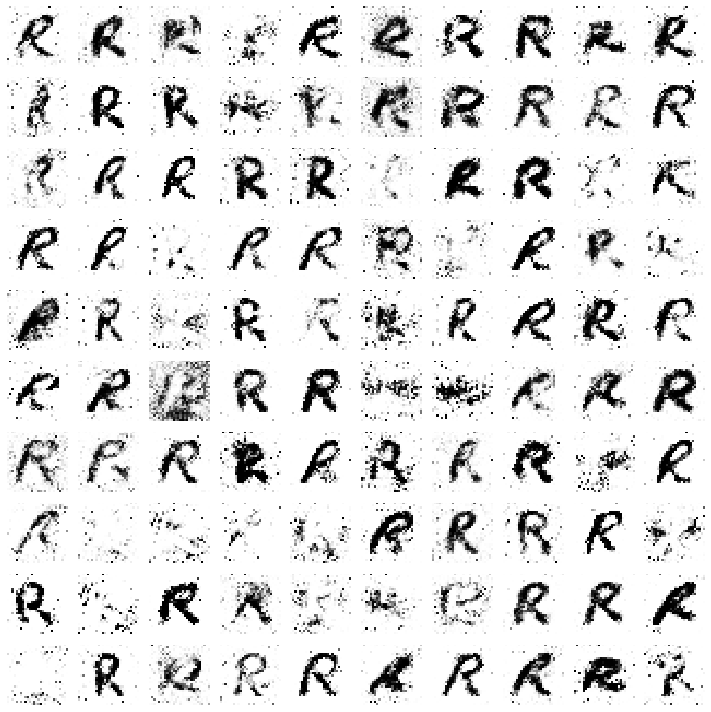

Epoch: 13 	 Discriminator Loss: 0.5367305874824524 		 Generator Loss: 1.9771342277526855


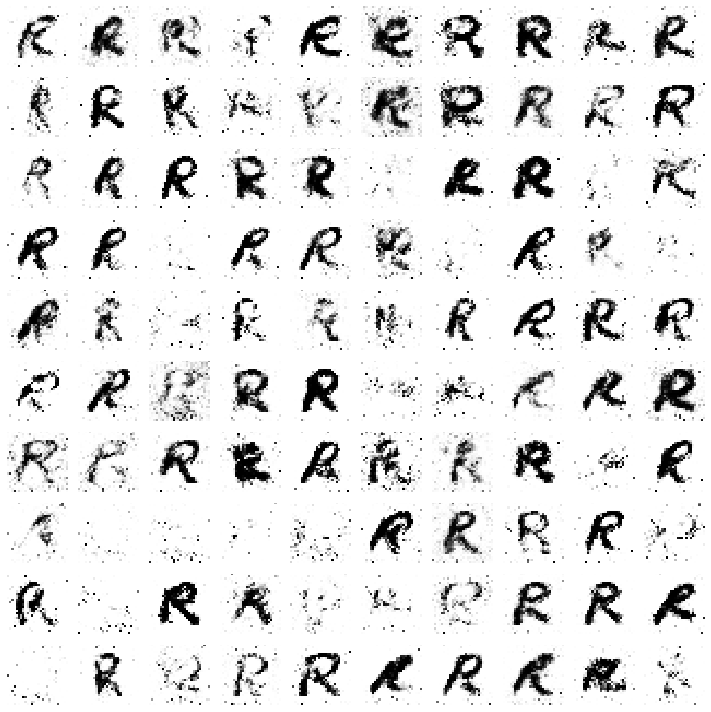

Epoch: 14 	 Discriminator Loss: 0.6425157785415649 		 Generator Loss: 1.0444833040237427


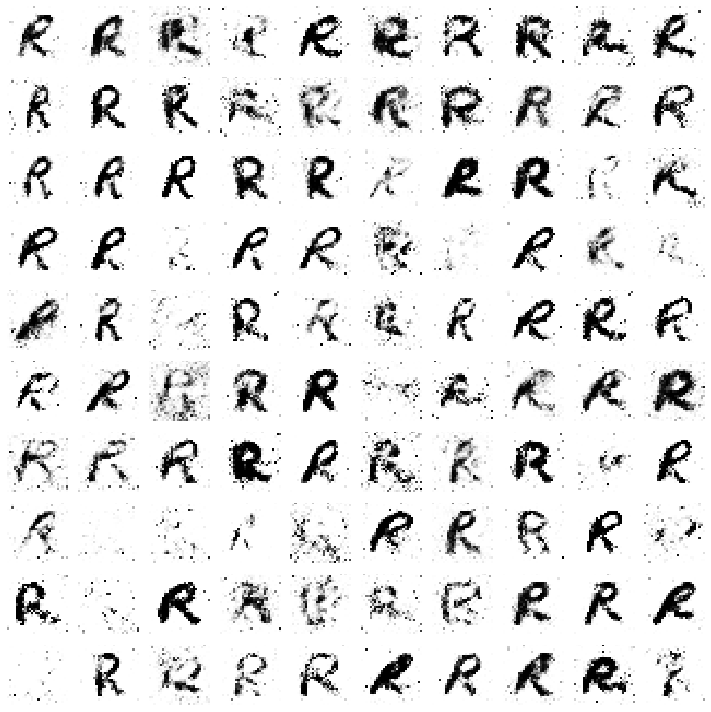

Epoch: 15 	 Discriminator Loss: 0.6499514579772949 		 Generator Loss: 1.4030115604400635


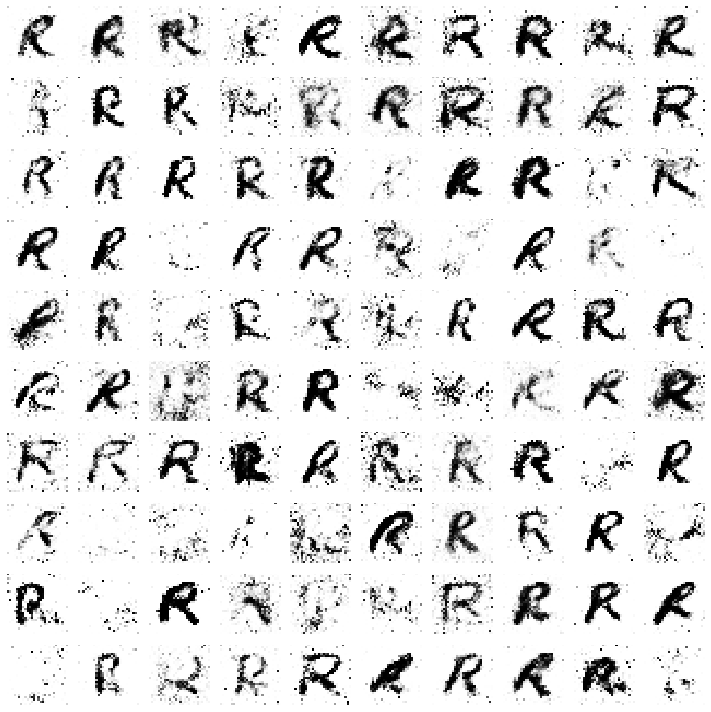

Epoch: 16 	 Discriminator Loss: 0.5205081105232239 		 Generator Loss: 1.7848446369171143


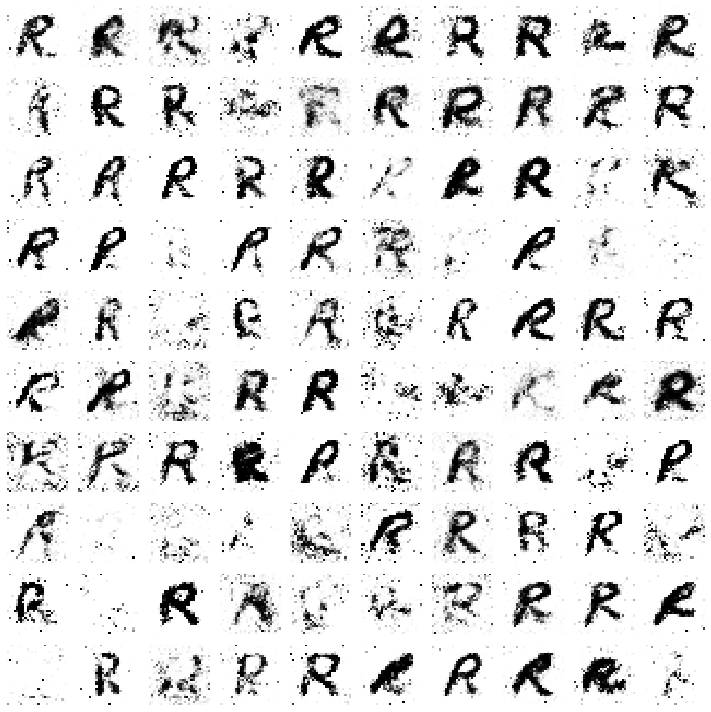

Epoch: 17 	 Discriminator Loss: 0.5167709589004517 		 Generator Loss: 1.8841993808746338


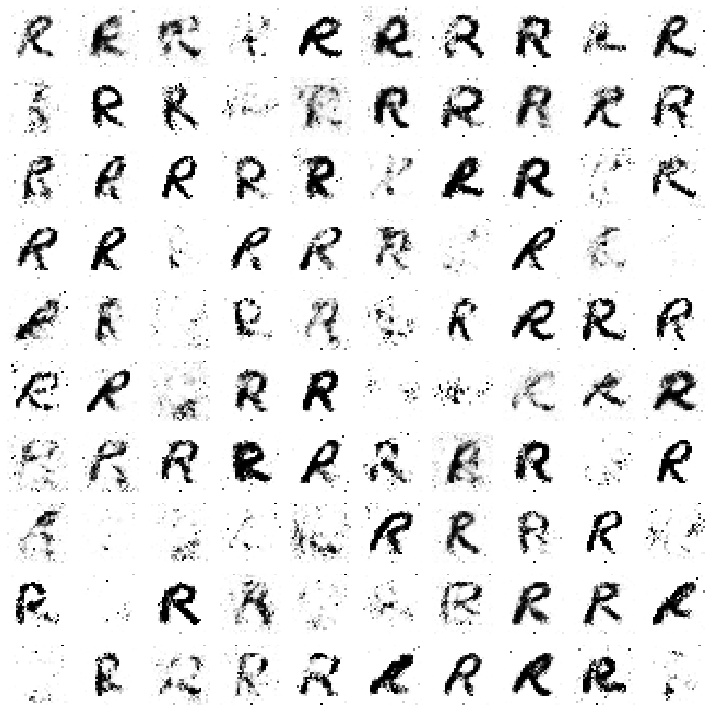

Epoch: 18 	 Discriminator Loss: 0.5881422758102417 		 Generator Loss: 1.5933127403259277


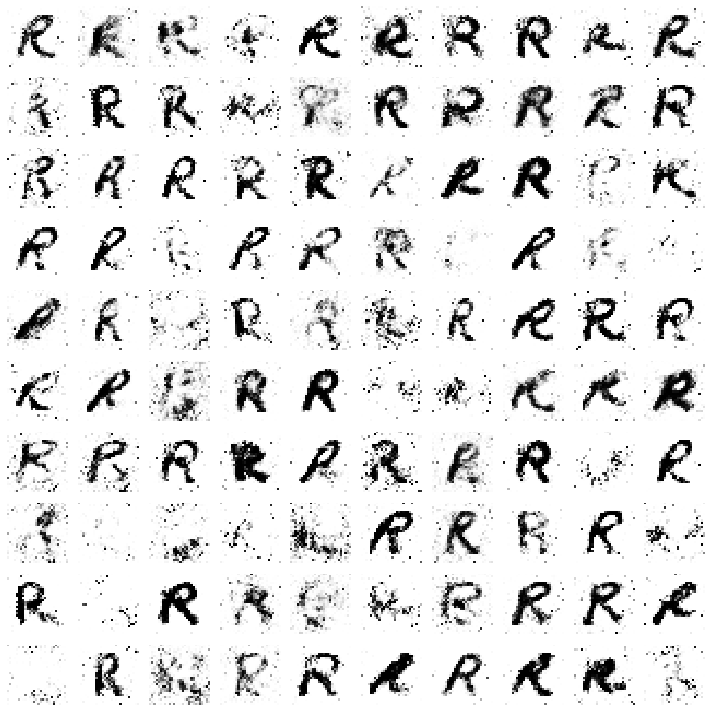

Epoch: 19 	 Discriminator Loss: 0.5550517439842224 		 Generator Loss: 1.4331035614013672


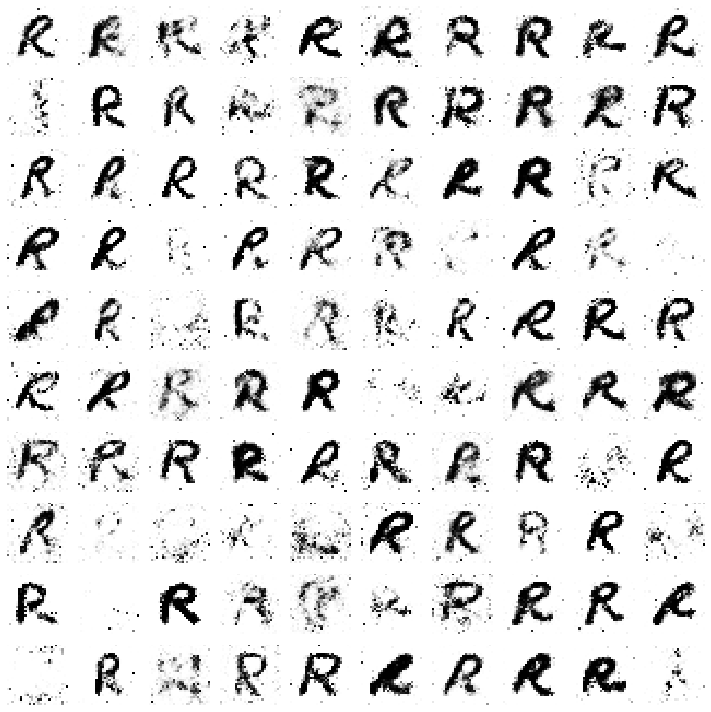

Epoch: 20 	 Discriminator Loss: 0.4640926122665405 		 Generator Loss: 1.6060800552368164


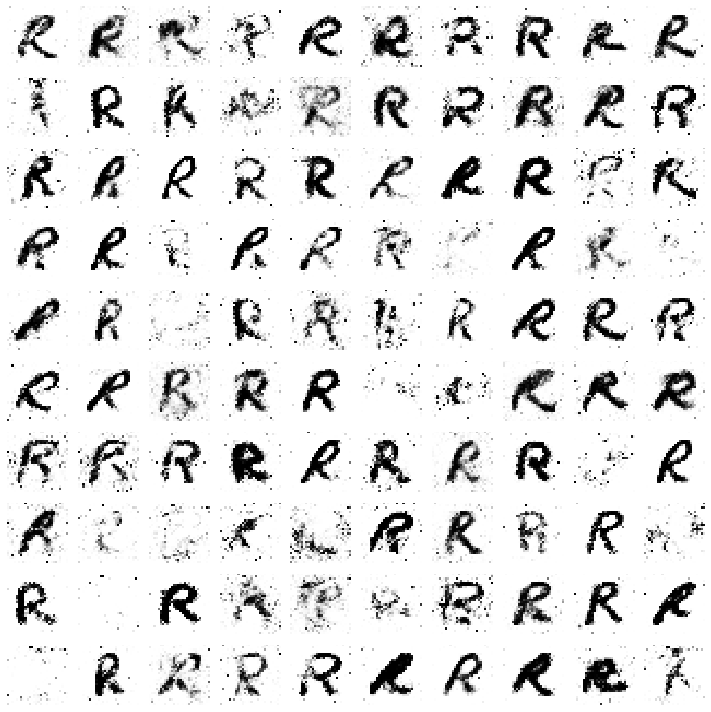

In [28]:
# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, vector_noise_dim))

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, vector_noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_final[np.random.randint(0, x_final.shape[0], size=batch_size)]
        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    #if epoch % 10 == 0:
    show_images(static_noise, epoch)

In [0]:
# Create path for saving gifs for generated images
gif_path = 'generated_gifs'
if gif_path != None and not os.path.isdir(gif_path):
    os.mkdir(gif_path)

In [0]:
# Turn the training process into a GIF and save it 
frames = []

for image in os.listdir(images_path):
    frames.append(Image.open(images_path + '/' + image))
frames[0].save(f'{gif_path}/gan_training_sword.gif', format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)


In [0]:
# Create path for saving trained models
model_path = 'train_models'
if model_path != None and not os.path.isdir(model_path):
    os.mkdir(model_path)

In [0]:
discriminator.save(f'{model_path}/gan_discriminator_sword.hdf5')
generator.save(f'{model_path}/gan_generator_sword.hdf5')